# 📦 1. Imports and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Load A/B testing dataset
df = pd.read_csv("C:/Users/ajinv/Downloads/project9_ab_data.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


## 🔍 2. Initial Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df['converted'].value_counts()

converted
0    259241
1     35237
Name: count, dtype: int64

In [5]:
df['user_id'].nunique()

290584

In [6]:
df['user_id'].duplicated().sum()  # Number of duplicate users

3894

In [7]:
# Get index of duplicate user IDs
drop_index = df[df['user_id'].duplicated()].index

In [8]:
drop_index

Index([  2656,   2893,   7500,   8036,  10218,  11215,  11428,  12858,  13262,
        14487,
       ...
       293996, 294014, 294200, 294252, 294253, 294308, 294309, 294328, 294331,
       294355],
      dtype='int64', length=3894)

In [9]:
# Drop duplicates and confirm
print(len(df.drop(drop_index , axis=0)))
print(df.drop(drop_index , axis=0)['user_id'].nunique())

290584
290584


## 🧹 3. Data Cleaning and Consistency Check

In [10]:
df1 = df.drop(drop_index , axis=0)

In [11]:
# Drop inconsistent treatment-control pairs
index_drop_control = df1[np.logical_and(df1['group']=='control', df1['landing_page']=='new_page')].index
index_drop_treatment = df1[np.logical_and(df1['group']=='treatment', df1['landing_page']=='old_page')].index

In [12]:
print(len(index_drop_control))
print(len(index_drop_treatment))

1006
1038


In [13]:
df1.drop(index_drop_control , axis=0 , inplace=True)
df1.drop(index_drop_treatment , axis=0 , inplace=True)

In [14]:
# Sanity check after cleaning
df1[np.logical_and(df1['group']=='treatment', df1['landing_page']=='old_page')]

,user_id,timestamp,group,landing_page,converted


In [15]:
df1.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## 📊 4. Conversion Rate Calculation

In [16]:
p_old = df1[df1['landing_page']=='old_page']['converted'].mean()
p_new = df1[df1['landing_page']=='new_page']['converted'].mean()

In [17]:
print(p_old)
print(p_new)

0.12029037760181936
0.11872721981235362


In [18]:
# Observed difference
p0 = p_new - p_old
print(p0)

-0.0015631577894657384


In [19]:
df1.shape[0]

288540

## 🔁 5. Bootstrapping Simulations

In [20]:
# Bootstrap simulation to compute sampling distribution
diff_p = []
for i in range(1000):
    df_boot = df1.sample(100000 , replace=True)
    p_old2 = df_boot[df_boot['landing_page']=='old_page']['converted'].mean()
    p_new2 = df_boot[df_boot['landing_page']=='new_page']['converted'].mean()
    diff_p.append(p_new2 - p_old2)

In [21]:
np.quantile(sorted(diff_p),[0.05])

array([-0.00486305])

## 📉 6. Visualize Bootstrapped Distribution

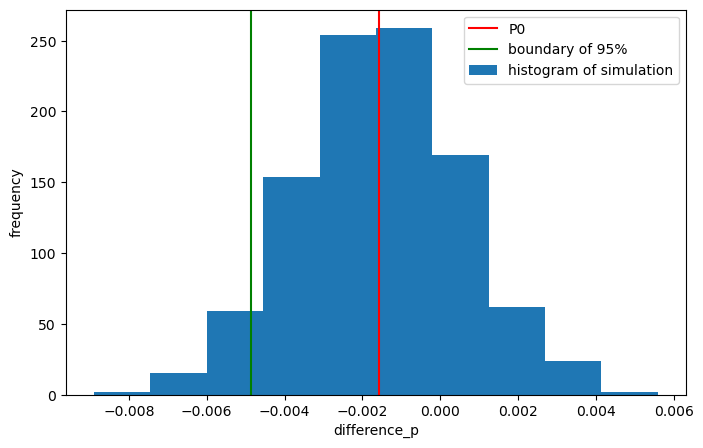

In [22]:
plt.figure(figsize=(8,5))
plt.hist(diff_p)
plt.axvline(p0 , color = 'red')
plt.axvline(np.quantile(sorted(diff_p),[0.05])[0] , color = 'green')
plt.xlabel('difference_p')
plt.ylabel('frequency')
plt.legend(['P0' , 'boundary of 95%' , 'histogram of simulation'])
plt.show()

## 🧮 7. p-value Estimation

In [23]:
len([i for i in sorted(diff_p) if i > p0]) / len(sorted(diff_p))

0.494

## 📐 8. Normal Approximation

In [24]:
mean_diff = np.mean(diff_p)
std_diff = np.std(diff_p)
print(mean_diff)
print(std_diff)

-0.0015728102799585798
0.002100738821290676


In [25]:
norm_data = np.random.normal(mean_diff, std_diff, 10000)

## 📈 9. Visualize Normal Distribution Approximation

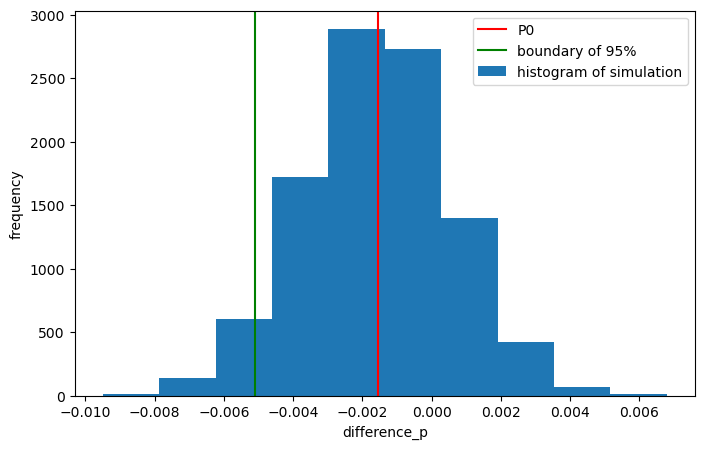

In [26]:
plt.figure(figsize=(8,5))
plt.hist(norm_data)
plt.axvline(p0 , color = 'red')
plt.axvline(np.quantile(sorted(norm_data),[0.05])[0] , color = 'green')
plt.xlabel('difference_p')
plt.ylabel('frequency')
plt.legend(['P0' , 'boundary of 95%' , 'histogram of simulation'])
plt.show()

## ✅ 10. Final p-value Estimation

In [27]:
len([i for i in sorted(norm_data) if i > p0]) / len(sorted(norm_data))

0.5033